In [28]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, avg, lit, udf, count, sum
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas
import numpy as np
import json
import requests
import os

from data_utils import get_date_range, get_data, clear_data
from datetime import datetime

In [29]:
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark.sparkContext)

In [30]:
# Get data for 2020 year
# Load data and group it by Language
df2020 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('data_april2020.csv', schema='Repo STRING, Language STRING, Comment STRING, Forks_Count INTEGER, Stargazers_count INTEGER, Open_issues_count INTEGER, Date TIMESTAMP')
df2020.printSchema()

df2020 = df2020.groupBy(col("Language"))

df2020 = df2020.agg(avg("Forks_Count").alias("Forks_Count"), count("Language").alias("Count"), avg("Stargazers_count").alias("Average_Stargazers_count"))

df2020 = df2020.sort(col("Count").desc())
most_popular_languages_2020 = df2020.toPandas().head(5)

root
 |-- Repo: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Comment: string (nullable = true)
 |-- Forks_Count: integer (nullable = true)
 |-- Stargazers_count: integer (nullable = true)
 |-- Open_issues_count: integer (nullable = true)
 |-- Date: timestamp (nullable = true)



In [48]:
# Same for 2021

# Load data and group it by Language
df2021 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('data_april2021.csv', schema='Repo STRING, Language STRING, Comment STRING, Forks_Count INTEGER, Stargazers_count INTEGER, Open_issues_count INTEGER, Date TIMESTAMP')

df2021 = df2021.groupBy(col("Language"))

df2021 = df2021.agg(avg("Forks_Count").alias("Forks_Count"), count("Language").alias("Count"), avg("Stargazers_count").alias("Average_Stargazers_count"))

df2021 = df2021.sort(col("Count").desc())
most_popular_languages_2021 = df2021.toPandas().head(5)

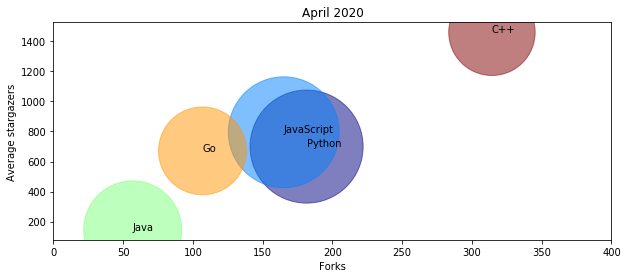

In [63]:
# Draw a plot
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, 5))

plt.rcParams["figure.figsize"] = (10, 4)
plt.scatter(
    x = most_popular_languages_2020["Forks_Count"],
    y = most_popular_languages_2020["Average_Stargazers_count"],
    s = most_popular_languages_2020["Count"]/15,
    alpha = 0.5,
    c = colors
)
plt.xlim([0, 400])
plt.title("April 2020")
plt.xlabel("Forks")
plt.ylabel("Average stargazers")
        
x,y = most_popular_languages_2020["Forks_Count"], most_popular_languages_2020["Average_Stargazers_count"]


#labels
for i, name in enumerate(most_popular_languages_2020["Language"]):
    plt.annotate(name, (x[i], y[i]))

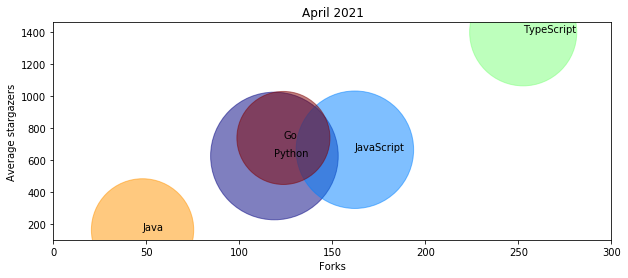

In [64]:
# Draw a plot
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0, 5))

plt.rcParams["figure.figsize"] = (10, 4)
plt.scatter(
    x = most_popular_languages_2021["Forks_Count"],
    y = most_popular_languages_2021["Average_Stargazers_count"],
    s = most_popular_languages_2021["Count"]/10,
    alpha = 0.5,
    c = colors
)
plt.xlim([0, 300])
plt.title("April 2021")
plt.xlabel("Forks")
plt.ylabel("Average stargazers")
        
x,y = most_popular_languages_2021["Forks_Count"], most_popular_languages_2021["Average_Stargazers_count"]


#labels
for i, name in enumerate(most_popular_languages_2021["Language"]):
    plt.annotate(name, (x[i], y[i]))

In [44]:
from pyspark.sql import functions as F

def get_companies_data(google_df, amazon_df, facebook_df):
    google_df_positive = google_df.filter((F.col('p')>=0.8))
    google_df_neutral = google_df.filter( (F.col('p')>=0.4) & (F.col('p')<0.8))
    google_df_negative = google_df.filter((F.col('p')<0.4))
    
    amazon_df_positive = amazon_df.filter((F.col('p')>=0.8))
    amazon_df_neutral = amazon_df.filter( (F.col('p')>=0.4) & (F.col('p')<0.8))
    amazon_df_negative = amazon_df.filter((F.col('p')<0.4))
    
    facebook_df_positive = facebook_df.filter((F.col('p')>=0.8))
    facebook_df_neutral = facebook_df.filter( (F.col('p')>=0.4) & (F.col('p')<0.8))
    facebook_df_negative = facebook_df.filter((F.col('p')<0.4))
    
    facebook_df.select(avg(F.col("p")).alias('Facebook')).show()
    amazon_df.select(avg(F.col("p")).alias('Amazon')).show()
    google_df.select(avg(F.col("p")).alias('Google')).show()
    
    results = [['Google', google_df_positive.count(), google_df_neutral.count(), google_df_negative.count()], 
           ['Amazon', amazon_df_positive.count(), amazon_df_neutral.count(), amazon_df_negative.count()], 
           ['Facebook', facebook_df_positive.count(), facebook_df_neutral.count(), facebook_df_negative.count()]]
    
    df = pandas.DataFrame(results, columns = ['Company', 'Negative', 'Neutral' ,'Positive'])
    df["Mean"] = (df.Neutral + df.Positive + df.Negative) / 3
    
    return df

# Get 2020 data
google_df2020 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('google2020.csv', schema='Repo STRING, Text STRING, p DOUBLE')

amazon_df2020 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('amazon2020.csv', schema='Repo STRING, Text STRING, p DOUBLE')

facebook_df2020 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('facebook2020.csv', schema='Repo STRING, Text STRING, p DOUBLE')

# Get 2021 data
google_df2021 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('google2021.csv', schema='Repo STRING, Text STRING, p DOUBLE')

amazon_df2021 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('amazon2021.csv', schema='Repo STRING, Text STRING, p DOUBLE')

facebook_df2021 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('facebook2021.csv', schema='Repo STRING, Text STRING, p DOUBLE')

companies2020 = get_companies_data(google_df2020, amazon_df2020, facebook_df2020)
companies2021 = get_companies_data(google_df2021, amazon_df2021, facebook_df2021)

+------------------+
|          Facebook|
+------------------+
|0.4607130592090048|
+------------------+

+------------------+
|            Amazon|
+------------------+
|0.4347481509891783|
+------------------+

+-------------------+
|             Google|
+-------------------+
|0.43940057878673705|
+-------------------+

+------------------+
|          Facebook|
+------------------+
|0.4463944466828306|
+------------------+

+-------------------+
|             Amazon|
+-------------------+
|0.44269737538647286|
+-------------------+

+-------------------+
|             Google|
+-------------------+
|0.42215112029771423|
+-------------------+



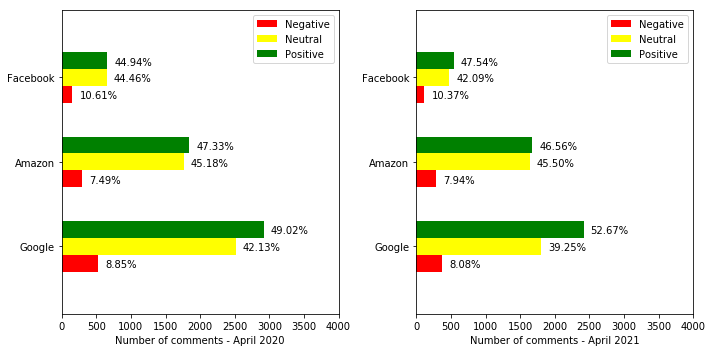

<Figure size 720x360 with 0 Axes>

In [45]:
ind = np.arange(len(companies2020))
width = 0.2

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax.ravel()[0].barh(ind, companies2020.Negative, width, color='red', label='Negative')
ax.ravel()[0].barh(ind + width, companies2020.Neutral, width, color='yellow', label='Neutral')
ax.ravel()[0].barh(ind + 2*width, companies2020.Positive, width, color='green', label='Positive')
ax.ravel()[0].set(yticks=ind + width, yticklabels=companies2020.Company, ylim=[2*width - 1, len(companies2020)])
ax.ravel()[0].legend()
ax.ravel()[0].set_xlim([0, 4000])
ax.ravel()[0].set_xlabel("Number of comments - April 2020")

for i, val in enumerate(companies2020.Negative):
    ax.ravel()[0].text(val + 100, i - 0.05, str("{:.2%}".format(val/companies2020["Mean"][i]/3)), color="black", fontsize=10)
for i, val in enumerate(companies2020.Neutral):
    ax.ravel()[0].text(val + 100, i + width - 0.05, str("{:.2%}".format(val/companies2020["Mean"][i]/3)), color="black", fontsize=10)
for i, val in enumerate(companies2020.Positive):
    ax.ravel()[0].text(val + 100, i + 2*width - 0.05, str("{:.2%}".format(val/companies2020["Mean"][i]/3)), color="black", fontsize=10)

ax.ravel()[1].barh(ind, companies2021.Negative, width, color='red', label='Negative')
ax.ravel()[1].barh(ind + width, companies2021.Neutral, width, color='yellow', label='Neutral')
ax.ravel()[1].barh(ind + 2*width, companies2021.Positive, width, color='green', label='Positive')
ax.ravel()[1].set(yticks=ind + width, yticklabels=companies2021.Company, ylim=[2*width - 1, len(companies2020)])
ax.ravel()[1].legend()
ax.ravel()[1].set_xlim([0, 4000])
ax.ravel()[1].set_xlabel("Number of comments - April 2021")

for i, val in enumerate(companies2021.Negative):
    ax.ravel()[1].text(val + 100, i - 0.05, str("{:.2%}".format(val/companies2021["Mean"][i]/3)), color="black", fontsize=10)
for i, val in enumerate(companies2021.Neutral):
    ax.ravel()[1].text(val + 100, i + width - 0.05, str("{:.2%}".format(val/companies2021["Mean"][i]/3)), color="black", fontsize=10)
for i, val in enumerate(companies2021.Positive):
    ax.ravel()[1].text(val + 100, i + 2*width - 0.05, str("{:.2%}".format(val/companies2021["Mean"][i]/3)), color="black", fontsize=10)

plt.tight_layout()
plt.show()
    
plt.savefig('companies_analysis.png')

In [46]:
def get_languages_data(js_df, python_df, java_df):
    js_df_positive = js_df.filter((F.col('p')>=0.8))
    js_df_neutral = js_df.filter( (F.col('p')>=0.4) & (F.col('p')<0.8))
    js_df_negative = js_df.filter((F.col('p')<0.4))
    
    python_df_positive = python_df.filter((F.col('p')>=0.8))
    python_df_neutral = python_df.filter( (F.col('p')>=0.4) & (F.col('p')<0.8))
    python_df_negative = python_df.filter((F.col('p')<0.4))
    
    java_df_positive = java_df.filter((F.col('p')>=0.8))
    java_df_neutral = java_df.filter( (F.col('p')>=0.4) & (F.col('p')<0.8))
    java_df_negative = java_df.filter((F.col('p')<0.4))
    
    results = [['JavaScript', js_df_positive.count(), js_df_neutral.count(), js_df_negative.count()], 
           ['Python', python_df_positive.count(), python_df_neutral.count(), python_df_negative.count()], 
           ['Java', java_df_positive.count(), java_df_neutral.count(), java_df_negative.count()]]
    
    df = pandas.DataFrame(results, columns = ['Language', 'Negative', 'Neutral' ,'Positive'])
    df["Mean"] = (df.Neutral + df.Positive + df.Negative) / 3
    
    return df

# Get 2020 data
js_df2020 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('js2020.csv', schema='Repo STRING, Text STRING, p DOUBLE')

python_df2020 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('python2020.csv', schema='Repo STRING, Text STRING, p DOUBLE')

java_df2020 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('java2020.csv', schema='Repo STRING, Text STRING, p DOUBLE')

# Get 2021 data
js_df2021 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('js2021.csv', schema='Repo STRING, Text STRING, p DOUBLE')

python_df2021 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('python2021.csv', schema='Repo STRING, Text STRING, p DOUBLE')

java_df2021 = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('java2021.csv', schema='Repo STRING, Text STRING, p DOUBLE')

lang2020 = get_languages_data(js_df2020, python_df2020, java_df2020)
lang2021 = get_languages_data(js_df2021, python_df2021, java_df2021)

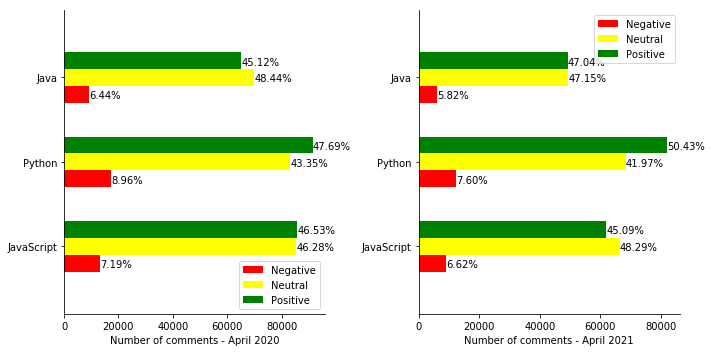

In [57]:
ind = np.arange(len(lang2020))
width = 0.2

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax.ravel()[0].barh(ind, lang2020.Negative, width, color='red', label='Negative')
ax.ravel()[0].barh(ind + width, lang2020.Neutral, width, color='yellow', label='Neutral')
ax.ravel()[0].barh(ind + 2*width, lang2020.Positive, width, color='green', label='Positive')
ax.ravel()[0].set(yticks=ind + width, yticklabels=lang2020.Language, ylim=[2*width - 1, len(lang2020)])
ax.ravel()[0].legend()
ax.ravel()[0].spines['right'].set_visible(False)
ax.ravel()[0].spines['top'].set_visible(False)
ax.ravel()[0].set_xlabel("Number of comments - April 2020")

for i, val in enumerate(lang2020.Negative):
    ax.ravel()[0].text(val + 100, i - 0.05, str("{:.2%}".format(val/lang2020["Mean"][i]/3)), color="black", fontsize=10)
for i, val in enumerate(lang2020.Neutral):
    ax.ravel()[0].text(val + 100, i + width - 0.05, str("{:.2%}".format(val/lang2020["Mean"][i]/3)), color="black", fontsize=10)
for i, val in enumerate(lang2020.Positive):
    ax.ravel()[0].text(val + 100, i + 2*width - 0.05, str("{:.2%}".format(val/lang2020["Mean"][i]/3)), color="black", fontsize=10)

ax.ravel()[1].barh(ind, lang2021.Negative, width, color='red', label='Negative')
ax.ravel()[1].barh(ind + width, lang2021.Neutral, width, color='yellow', label='Neutral')
ax.ravel()[1].barh(ind + 2*width, lang2021.Positive, width, color='green', label='Positive')
ax.ravel()[1].set(yticks=ind + width, yticklabels=lang2021.Language, ylim=[2*width - 1, len(lang2021)])
ax.ravel()[1].legend()
ax.ravel()[1].spines['right'].set_visible(False)
ax.ravel()[1].spines['top'].set_visible(False)
ax.ravel()[1].set_xlabel("Number of comments - April 2021")

for i, val in enumerate(lang2021.Negative):
    ax.ravel()[1].text(val + 100, i - 0.05, str("{:.2%}".format(val/lang2021["Mean"][i]/3)), color="black", fontsize=10)
for i, val in enumerate(lang2021.Neutral):
    ax.ravel()[1].text(val + 100, i + width - 0.05, str("{:.2%}".format(val/lang2021["Mean"][i]/3)), color="black", fontsize=10)
for i, val in enumerate(lang2021.Positive):
    ax.ravel()[1].text(val + 100, i + 2*width - 0.05, str("{:.2%}".format(val/lang2021["Mean"][i]/3)), color="black", fontsize=10)

plt.tight_layout()
plt.show()